In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [6]:
def phase_oracle(n, indices_to_make, name='Magic'):
    qc = QuantumCircuit(n,name=name)
    matx =np.identity(2**n)
    for index in indices_to_make:
        matx[index,index]=-1
    qc.unitary(Operator(matx),range(n))
    qc.draw()
    return qc


def diffuser(n):
    qc = QuantumCircuit(n,name='Diff')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    qc.draw()
    return qc

# big ball of wibbly-wobbly, timey-wimey
def something(n,marked):
    qc = QuantumCircuit(n, n)
    print(f'{n} qubits, basis state {marked} marked')
    qc.h(range(n))
    qc.append(phase_oracle(n,marked),range(n))
    qc.append(diffuser(n),range(n))
    
    qc.measure(range(n),range(n))
    return qc

5 qubits, basis state [15] marked


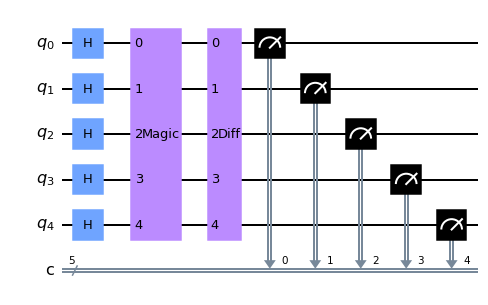

In [7]:
n=5
x=np.random.randint(20)
marked=[x]
qc=something(n,marked)

qc.draw()

{'00110': 36, '11010': 35, '01100': 50, '01000': 44, '01110': 40, '01101': 59, '00001': 45, '00100': 47, '00011': 41, '11001': 60, '10111': 51, '11000': 50, '11110': 45, '11100': 47, '00010': 59, '10101': 59, '10000': 53, '11011': 55, '01111': 535, '10001': 57, '01010': 64, '00101': 46, '01001': 51, '10100': 47, '11101': 44, '10110': 43, '10010': 54, '11111': 42, '10011': 49, '00111': 52, '01011': 54, '00000': 34}


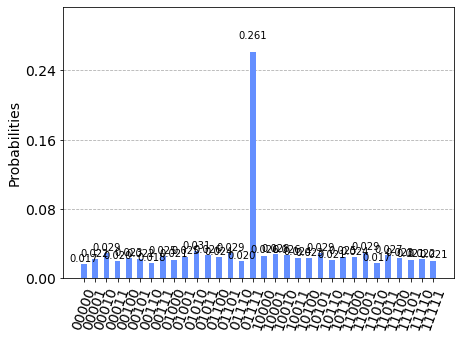

In [8]:
back = Aer.get_backend('qasm_simulator')
result = execute(qc,back,shots=2048).result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)

In [9]:
def live(nh):
    v=nh
    a=0
    for i in [0,2]:
        a+=(v[1][1][i]+v[i][1][1]+v[1][i][1])/2
    for i in [0,2]:
        a+=(v[0][i][0]+v[0][i][2]+v[2][i][0]+v[2][i][2])/8
    a+=(v[1][0][0]+v[1][2][2]+v[1][2][0]+v[1][0][2]+v[0][0][1]+v[0][1][0]+v[0][1][2]+v[0][2][1]+v[2][0][1]+v[2][1][0]+v[2][1][2]+v[2][2][1])/4
    return a

def gol(nh):
    a=live(nh)
    v=nh[1][1][1]
    alive = np.array([1.0,0.0])
    dead = np.array([0.0,1.0])
    B = np.array([[0,0],[1,1]])
    D = np.array([[1,1],[0,0]])
    S = np.array([[1,0],[0,1]])
    
    if a <= 1:
        value =  dead
    elif (a > 1 and a <= 3):
        value = ((np.sqrt(2)+1)*2-(np.sqrt(2)+1)*a)*dead+(a-1)*value#(((np.sqrt(2)+1)*(2-a))**2+(a-1)**2)
    elif (a > 3 and a <= 4):
        value = (((np.sqrt(2)+1)*3)-(np.sqrt(2)+1)*a)*value+(a-2)*alive#(((np.sqrt(2)+1)*(3-a))**2+(a-2)**2)
    elif (a > 4 and a < 5):
        value = ((np.sqrt(2)+1)*4-(np.sqrt(2)+1)*a)*alive+(a-3)*dead#(((np.sqrt(2)+1)*(4-a))**2+(a-3)**2)
    elif a >= 5:
        value = dead
        
    value = value/np.linalg.norm(value)
    return value

def complex_idk_stuff(nh):
    v=nh
    a=live(nh)
    a = a/np.linalg.norm(a)
    qc = QuantumCircuit(5,name='hehe')
    

